In [14]:
import matplotlib.pyplot as plt
import numpy
import importlib 
import matplotlib.patches as patches

## Fix size of all fonts in figures: for texts
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
cm2in = 1/2.54
fig_format = '.png'
myColors = ['#626262', '#184e77', '#1A759F', '#34A0A4', '#76C893', '#B5E48C', '#EBF297']

## Reload files:
import Libs.Subroutines
importlib.reload(Libs.Subroutines);

from Libs.Subroutines import MESH
from Libs.Subroutines import preProcess
from Libs.Subroutines import loadMesh
from Libs.Subroutines import findNearest
from Libs.Subroutines import findInterval

## Characteristics of the flow:
Uinf = 4
Pdyn = 0.5 * Uinf**2

filenames = 'OFData'
timenames = '678'
casedescrip = 'BEM actuator'
linestyle = '-'

## 2. Plot pressure and velocity over center line of the actuator

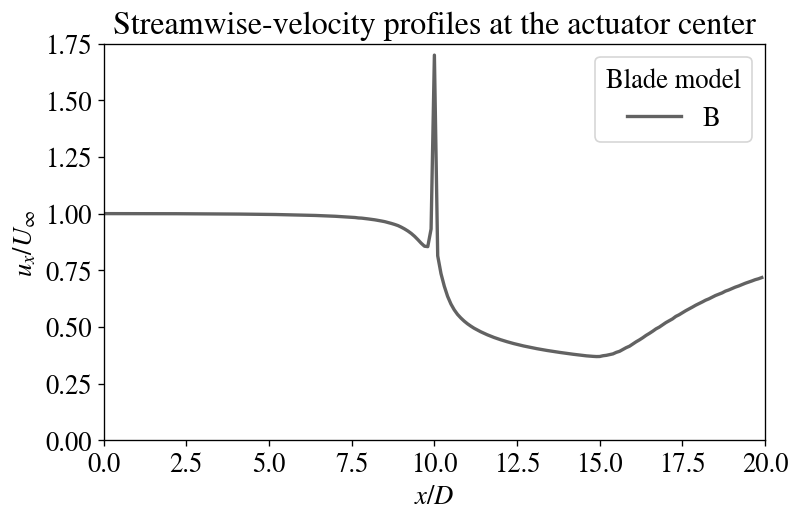

In [25]:
fig, ax = plt.subplots(figsize=(20*cm2in, 12*cm2in), dpi=120)
plt.subplots_adjust(left=0.15, bottom=0.2, right=0.85, top=0.9)

mesh = loadMesh(filenames)
X = mesh.X
Y = mesh.Y
Z = mesh.Z
P = mesh.P
Ux = mesh.Ux

yindex = abs(mesh.y-1).argmin() 
zindex = abs(mesh.z-10).argmin() 

xline = X[:, yindex, zindex]
uline = Ux[:, yindex, zindex] / Uinf

ax.plot(xline, uline, linestyle[0], linewidth=2, color=myColors[0], label = casedescrip)

## Setting axis labels
ax.set_title('Streamwise-velocity profiles at the actuator center')
ax.set_ylabel(r'$u_x/U_{\infty}$')
ax.set(xlim=(0,20), ylim=(0,1.75))
ax.legend(title='Blade model', loc='upper right')
ax.set_xlabel(r'$x/D$');

plt.savefig("./images/u_x_velocity_profiles.png", dpi=300, bbox_inches="tight")

## 2. Plot cross-section of grid

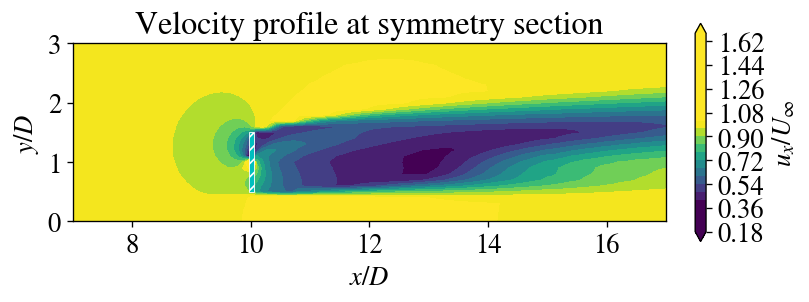

In [41]:
fig, ax = plt.subplots(figsize=(20*cm2in, 15*cm2in), dpi=120)

ax.set_title('Velocity profile at symmetry section')
fig.subplots_adjust(hspace=0.1, wspace=0.1)

mesh = loadMesh(filenames)
X = mesh.X
nx, ny, nz = X.shape

ucontour = ax.contourf(mesh.X[:, :, nz//2], 
                       mesh.Y[:, :, nz//2], 
                       mesh.Ux[:, :, nz//2]/Uinf, 
                       extend='both', levels=30, vmin=0.4, vmax=1.0)


## Create a Rectangle patch
rect1 = patches.Rectangle((9.98, 0.5), 0.08, 1.0, linewidth=0.5, edgecolor='w', hatch='///', zorder=2, fc='c')
ax.add_patch(rect1)

cbar = fig.colorbar(ucontour, ax=ax, pad=0.04, shrink=0.4)
cbar.set_label(r'$u_x/U_{\infty}$')

ax.set_xlabel(r'$x/D$')
ax.set_ylabel(r'$y/D$')
ax.set(xlim=(7,17), ylim=(0,3))
ax.set_aspect(1)


plt.savefig("./images/crossflow_velocity_fields.png", dpi=300, bbox_inches="tight")

## 3. Plot results over different cross-flow sections

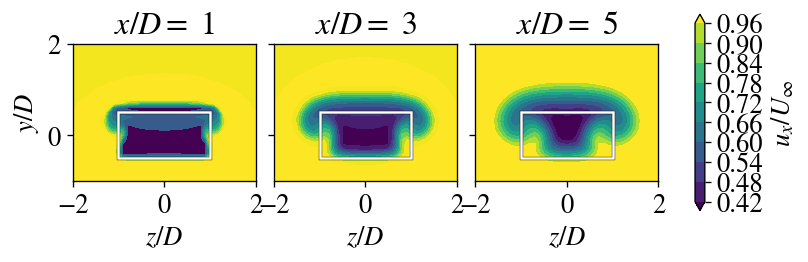

In [39]:
## Get the indexes in the grid where x=xcoord
xcoords = [11,13,15]
indexes = findNearest(mesh.x, xcoords) # plot fields at x[indexes]-locations


fig, axs = plt.subplots(1,len(indexes), figsize=(20*cm2in, 9*cm2in), dpi=120)
fig.subplots_adjust(hspace=0.1, wspace=0.1)

mesh = loadMesh(filenames)

for i, index in enumerate(indexes):   

      ucontour = axs[i].contourf(mesh.Z[index, :, :]-10, 
                                    mesh.Y[index, :, :]-1, 
                                    mesh.Ux[index, :, :]/Uinf,
                                    extend='both', levels=10, vmin=0.4, vmax=1.0)
      axs[i].set_aspect(1)
      axs[i].set_xlabel(r'$z/D$')
      axs[i].set_ylabel(r'$y/D$')
      axs[i].set(xlim=(-2,2), ylim=(-1,2))
      axs[i].set_title( r'$x/D=$ %0.0f' % (xcoords[i]-10) )
            

      ## Create a rectangular patch:
      rect1 = patches.Rectangle((-1, -0.5), 2, 1, linewidth=2.0, edgecolor='black', facecolor='none') 
      rect2 = patches.Rectangle((-1, -0.5), 2, 1, linewidth=1.5, edgecolor='white', facecolor='none') 
      axs[i].add_patch(rect1)
      axs[i].add_patch(rect2)


cbar = fig.colorbar(ucontour, ax=axs, pad=0.05, shrink=0.6)
cbar.set_label(r'$u_x/U_{\infty}$')

for ax in fig.get_axes(): ## Remove unnecessary ticks:
        ax.label_outer()

plt.savefig("./images/crossflow_sections.png", dpi=300, bbox_inches="tight")

## 4. Get total pressure across actuator plane:

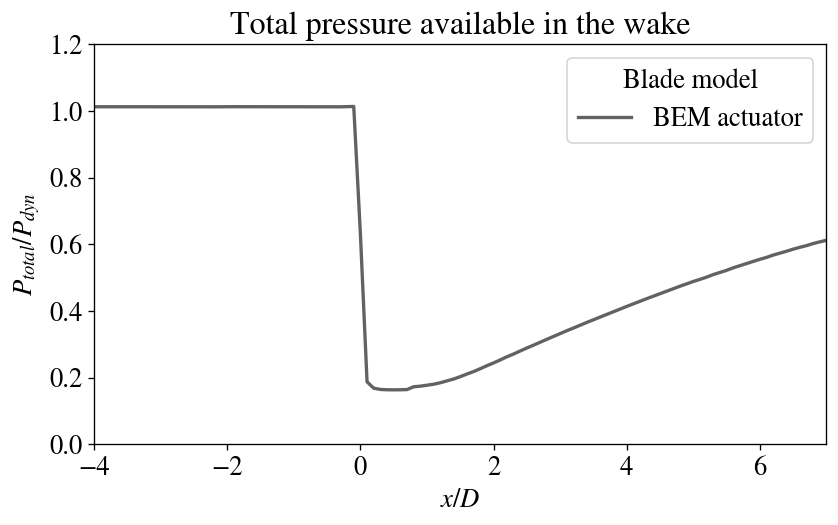

In [46]:
fig, ax = plt.subplots(figsize=(20*cm2in, 11*cm2in), dpi=120)


mesh = loadMesh(filenames)

## Get the indexes in the grid where y in [ylim] and z in [zlim]:
ymin, ymax = 0.5, 1.5
zmin, zmax = 9.0, 11.0

yindex = findInterval(mesh.y, ymin, ymax)
zindex = findInterval(mesh.z, zmin, zmax)

## Determine total pressure field:
y = mesh.y[yindex[0]:yindex[1]]
z = mesh.z[zindex[0]:zindex[1]]
x = mesh.x
nx = len(x)

coef = 1 / (len(y)*len(z))

P = mesh.P[:, yindex[0]:yindex[1], zindex[0]:zindex[1]]

Ux = mesh.Ux[:, yindex[0]:yindex[1], zindex[0]:zindex[1]]
Uy = mesh.Uy[:, yindex[0]:yindex[1], zindex[0]:zindex[1]]
Uz = mesh.Uz[:, yindex[0]:yindex[1], zindex[0]:zindex[1]]

Ptotal = P + 0.5 * (Ux**2 + Uy**2 + Uz**2)

## Get total pressure at this locations:]
ptotal = numpy.zeros(nx)

for i in range(nx):  
      ptotal[i] = numpy.nansum( Ptotal[i, :, :]  ) * coef

## Plot the total pressure behind the actuator:
ax.plot(x-10, ptotal / Pdyn, linestyle, linewidth=2, color=myColors[2*c], label = casedescrip)


ax.set_title('Total pressure available in the wake')
ax.legend(title='Blade model', loc='upper right')
ax.set_ylabel(r'$P_{total}/P_{dyn}$');
ax.set(xlim=(-4,7), ylim=(0,1.2))
ax.set_xlabel(r'$x/D$');

plt.savefig("./images/total_pressure_along_downwind.png", dpi=300, bbox_inches="tight")